##### Setup Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

###### Initialise Styling

In [2]:
%%html
<style>
table {
    position: relative;
    left: 0;
    padding-left: 0;
    margin-left: 0 !important;
}
span {
    font-size:1em;
}
</style>

##### Initialise helper functions

In [3]:
def hist_plot(title, columns, colours, nrows, ncols, index_pos, left=0.125, top=0.9, bottom=0.1, right=0.9, wspace=0.3, hspace=0.7):
    """
    Plots a histogram.
    :param title:     The title of the histogram.
    :param columns:   The data columns to plot on the histogram.
    :param colours:   The colours for each data column on the histogram.
    :param nrows:     The number of rows in the presentation table.
    :param ncols:     The number of columns in the presentation table.
    :param index_pos: The index of the histogram on the
    :param left:      How far to move away from left.
    :param top:       How far to move away from top.
    :param bottom:    How far to extend towards bottom.
    :param right:     How far to extend boundary towards right.
    :param wspace:    Height ratio spacing between plots.
    :param hspace:    Width ratio spacing between plots.
    :return:
    """
    plt.subplot(nrows,ncols,index_pos)
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
    for index_pos, column in enumerate(columns):
        plt.hist(column, alpha=0.3, color=colours[index_pos % len(colours)], density=True)
    plt.title(title)
    plt.xticks(rotation='vertical')

def classify_length_of_stay(length_of_stay):
    """
    Classifies length of stay into Class 0 if its < 4 days, or Class 1 otherwise.
    :param length_of_stay: The number of days stayed at hospital.
    :return: integer 0 or 1, representing class 0 or class 1.
    """
    return 0 if length_of_stay < 4 else 1

In [4]:
# Load the dataset
raw_dataFrame = pd.read_csv('./data/train_data.csv', delimiter=',')
raw_dataFrame.describe()

,ID,CCSProcedureCode,APRSeverityOfIllnessCode,BirthWeight,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode,LengthOfStay
count,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000
mean,29983.500000,155.404229,1.254594,3336.298903,2372.806690,7979.126922,2396.414318,7958.472668,59.811143,2.538405
std,17310.837458,89.541978,0.546207,446.244475,639.755096,3220.291347,1248.501189,3859.294711,21.470170,1.171246
min,1.000000,-1.000000,1.000000,2500.000000,712.000000,1243.000000,457.000000,1120.000000,28.000000,1.000000
25%,14992.250000,115.000000,1.000000,3000.000000,2041.000000,4620.000000,1551.000000,4438.000000,45.000000,2.000000
50%,29983.500000,220.000000,1.000000,3300.000000,2533.000000,9227.000000,1967.000000,7945.000000,55.000000,2.000000
75%,44974.750000,228.000000,1.000000,3600.000000,2785.000000,10644.000000,2895.000000,11619.000000,74.000000,3.000000
max,59966.000000,231.000000,4.000000,7500.000000,3242.000000,11381.000000,8114.000000,18466.000000,115.000000,10.000000


In [5]:
pd.isna(raw_dataFrame).sum()

ID                              0
HealthServiceArea               0
Gender                          0
Race                            0
TypeOfAdmission                 0
CCSProcedureCode                0
APRSeverityOfIllnessCode        0
PaymentTypology                 0
BirthWeight                     0
EmergencyDepartmentIndicator    0
AverageCostInCounty             0
AverageChargesInCounty          0
AverageCostInFacility           0
AverageChargesInFacility        0
AverageIncomeInZipCode          0
LengthOfStay                    0
dtype: int64

In [6]:
# Drop non-attribute columns
patients_X = raw_dataFrame.drop(['ID', 'HealthServiceArea', 'LengthOfStay'], axis=1)
dataFrame = raw_dataFrame.drop(['ID', 'HealthServiceArea'], axis=1)

# Assign column 'LengthOfStay' as Y target and transform it into 0 if length_of_stay < 4 else 1.
dataFrame['LengthOfStay'] = np.array(list(map(classify_length_of_stay, dataFrame['LengthOfStay'])))
patients_Y = dataFrame['LengthOfStay']

# 1 - Exploratory Data Analysis

The data is assumed to be made of entirely by newborn babies according to the assignment forums.\

### 1.1 - Exploring the distribution of the data
In this section the data's distribution of values are examined. Observations and folowwing conclusions are made to be used for  justifying the decisions made in the rest of the report.

######  1.1.1 Exploring unique values and data types
Here the fields display the unique values there are and their frequency.

In [7]:
for field in patients_X.columns:
    df = raw_dataFrame.groupby(field)['ID'].nunique()
    print(df)
print(raw_dataFrame.shape)

Gender
F    28987
M    30978
U        1
Name: ID, dtype: int64
Race
Black/African American     8183
Multi-racial                526
Other Race                18314
White                     32943
Name: ID, dtype: int64
TypeOfAdmission
Elective       154
Emergency      659
Newborn      58741
Urgent         412
Name: ID, dtype: int64
CCSProcedureCode
-1        769
 0      11189
 115    13628
 216      740
 220    10773
 228    19886
 231     2981
Name: ID, dtype: int64
APRSeverityOfIllnessCode
1    47953
2     8760
3     3252
4        1
Name: ID, dtype: int64
PaymentTypology
Blue Cross/Blue Shield       12073
Federal/State/Local/VA         849
Managed Care, Unspecified      545
Medicaid                     28723
Medicare                        44
Miscellaneous/Other            118
Private Health Insurance     15608
Self-Pay                      1984
Unknown                         22
Name: ID, dtype: int64
BirthWeight
2500    1407
2600    1758
2700    2250
2800    3057
2900    3630
3000 

###### 🧐 **Observations:**
> - Gender has 1 record for 'U'. 
> - APRSeverityOfIllnessCode has 1 record for '4'.
> - BirthWeight is rounded/categorised into the nearest 100 category. They are almost evenly spaced except 5900, as well as other spacings do not exist, as there is not data to represent them, therefore this has to be ordinal.
> - BirthWeight contains a lot of rare values in the upper weights.
> - There is a lot of data.

###### 👨🏻‍🎓 Conclusions

| Column Name                  |      Data Type
|:-----------------------------|:----------------------
| Gender                       |  Nominal
| Race                         |  Nominal
| TypeOfAdmission              |  Nominal
| CCSProcedureCode             |  Nominal
| APRSeverityOfIllnessCode     |  Ordinal
| PaymentTypology              |  Nominal
| BirthWeight                  |  Ordinal
| EmergencyDepartmentIndicator |  Nominal
| AverageCostInCounty          |  Discrete Numerical
| AverageChargesInCounty       |  Discrete Numerical
| AverageCostInFacility        |  Discrete Numerical
| AverageChargesInFacility     |  Discrete Numerical
| AverageIncomeInZipCode       |  Discrete Numerical
> - CCSProcedureCode would need to be encoded because, though it is numerical, it is not ordinal.
> - In Logistical regression APRSeverityOfIllnessCode would not need to be encoded since it is numerical and ordinal, this would help reduce the amount of features as input.
> - Use PowerTransformer or QuantileTransformer for the skewed fields.
> - Nominal Categorical fields will also need to be encoded because using only a numeric placeholder for their string value will make higher numbers show more importance than lower numbers, warping the training and results. This should be tested with One Hot Encoding and other encoders.
> - Accuracy is the most important thing when it comes to classification. One must strive to achieve the highest accuracy as long as time is not a constraint. Since there is so much data, Hold out validation would be a very power data splitting technique. K-fold would take a lot longer to complete but if left over night, could also potentiall provide good results for splitting the data evenly and fairly, for better accuracy scores. Both of these splitting methods will be analysed.
> - Due to a lot of the features being categorical, using models that don't need

In [8]:
# Split the fields up into their data types as different algorithms will only work on certain types of data. i.e One Hot Encoding

# Fields that are unordered categories
nominal_categorical_features = ['Gender','Race', 'TypeOfAdmission', 'CCSProcedureCode', 'PaymentTypology', 'EmergencyDepartmentIndicator']

# All other features are ordernal & numerical
ordinal_numerical_features = list(set(patients_X.columns).difference(set(nominal_categorical_features)))

###### 1.1.2 - Visualising the data distribution
Here histograms are used to determine trends and patterns in the frequency of the data and the it's values.

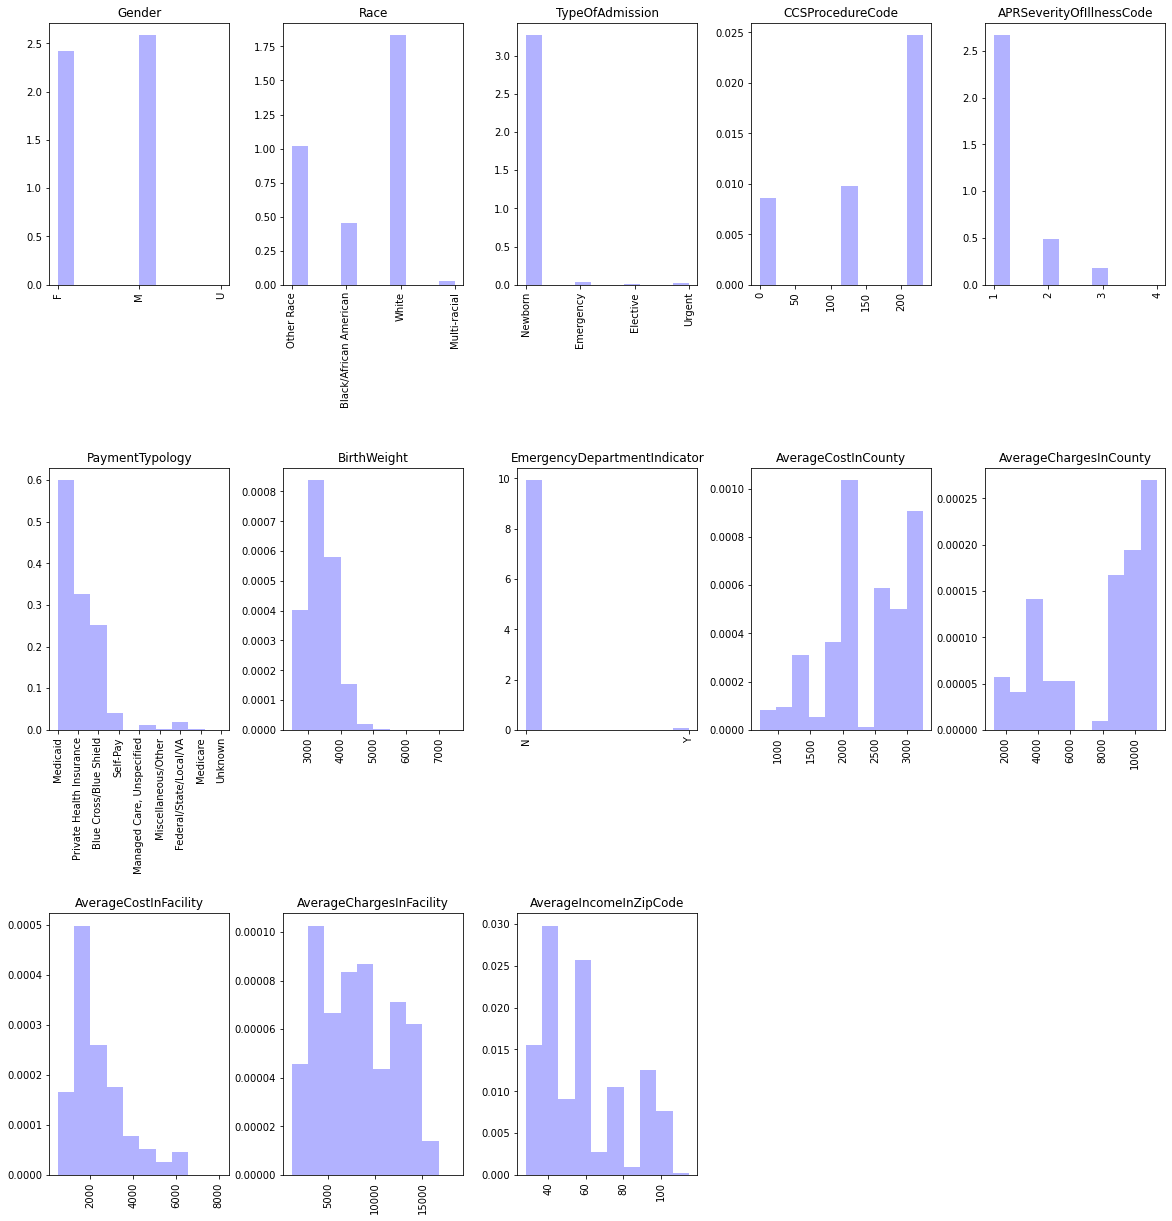

In [9]:
plt.figure(figsize=(20,20))
for i, col in enumerate(patients_X.columns):
    hist_plot(col, [patients_X[col]], ['b'], 3, 5, i+1)

###### 🧐 **Observations:**
> - Most categorical fields are not ordered. 
> - Categorical fields will need a numerical representation to be used in the ML model. 
> - For the field 'TypeOfAdmission', Emergency, Elective and Urgent are rare categories, most newborn babies have normal admissions as 'Newborn'.
> - Average Charges In Facility have very high values.
> - Rare categorical values:
    - Gender: Unknown 
    - Severity-of-illness-code: 4
    - EmergencyDepartmentIndicator: Yes 
    - PaymentTopology: SelfPay
    - PaymentTopology: Misc/Other
    - PaymentTopology: Medicare
    - PaymentTopology: Unknown 
    - TypeOfAdmission: Emergency  
> - TypeOfAdmission, the EmergencyDepartmentIndicator together shows that most hospital admissions were not emergencies.
> - EmergencyDepartmentIndicator is extremely biased to Y.\
| Column Name                  |      Observation
|:-----------------------------|:----------------------
| Gender                       |  Well distributed between 'M' and 'F', but 'U' is extremely under-represented.
| Race                         |  Not much data for multi-race newborns
| TypeOfAdmission              |  Bias towards 'Newborn' value, don't have much data on the other forms of admissions.
| CCSProcedureCode             |  Bias to codes in 200 area
| APRSeverityOfIllnessCode     |  Bias to code 1, right-skewed distribution
| PaymentTypology              |  Contais small values in some categories, not much representation.
| BirthWeight                  |  right-skewed distribution
| EmergencyDepartmentIndicator |  Extremely Bias to No
| AverageCostInCounty          |  left-skewed distribution, contains odd gap in data
| AverageChargesInCounty       |  left-skewed distribution, contains odd gap in data
| AverageCostInFacility        |  right-skewed distribution
| AverageChargesInFacility     |  slight right-skew distribution
| AverageIncomeInZipCode       |  right-skewed distribution

###### 👨🏻‍🎓 Conclusions
> - Average Charges In Facility shows that numeric values will need to be scaled i.e MinMax or other 
> - The Skewed data fields will need to be normalised. i.e PowerTransformer or other transformers.
> - EmergencyDepartmentIndicator indicates that for a Performance evaluation, precision will do really well because most of the data falled under 'Yes', yet be decieving because the model might be randomly guessing and still get high precision. Avoid precision being credible with this dataset for the performance evaluation.
> - TypeOfAdmission is also heavily biased towards Newborn category, so just by random judgment you are going to get Newborn correct 90% of the time. 
> - There are quite a few left skewed datasets as well and that will also make precision a bad indicator as a performance measure alone.

###### 1.1.3 - Visualising Outliers in the Data
Following on from the conclusion made in 1.1.2, the fields here will be examined for outliers.

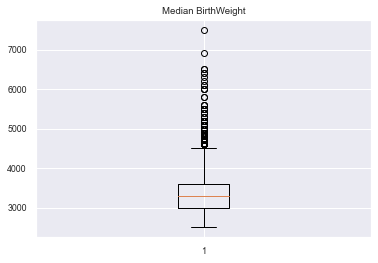

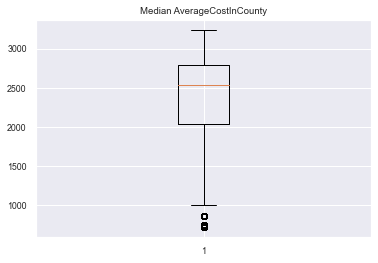

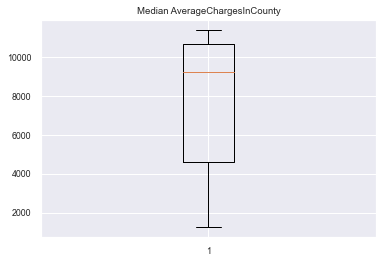

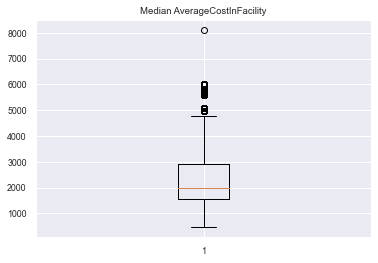

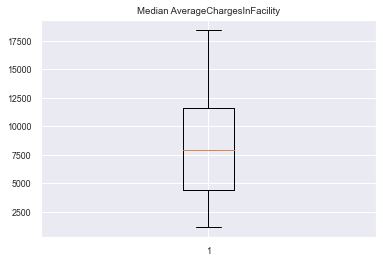

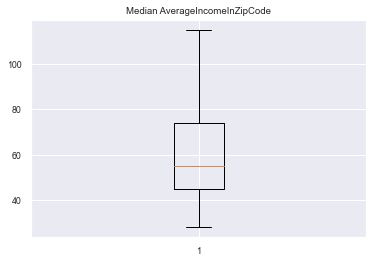

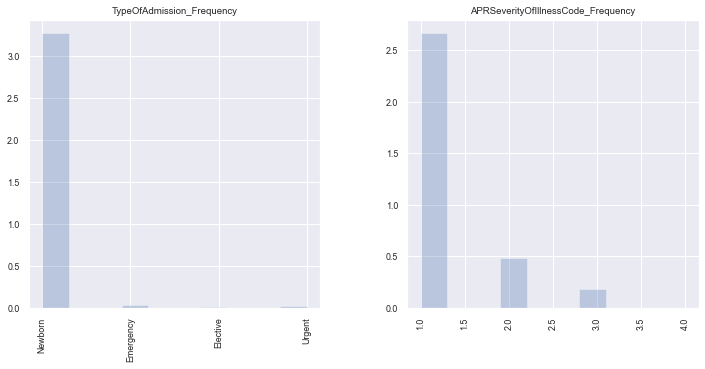

In [95]:
skewedFieldsObserved = ['BirthWeight', 'AverageCostInCounty', 'AverageChargesInCounty', 'AverageCostInFacility', 'AverageChargesInFacility', 'AverageIncomeInZipCode']
for field in skewedFieldsObserved:
    plt.boxplot(dataFrame[field])
    plt.title('Median ' + field)
    plt.show()

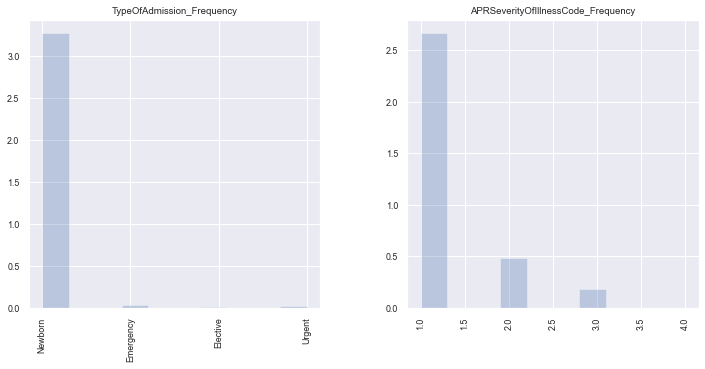

In [96]:
plt.figure(figsize=(12,5))
hist_plot('TypeOfAdmission_Frequency', [dataFrame['TypeOfAdmission']], ['b'], 1, 2, 1)
hist_plot('APRSeverityOfIllnessCode_Frequency', [dataFrame['APRSeverityOfIllnessCode']], ['b'], 1, 2, 2)

###### 🧐 **Observations:**
> - Out of all the numeric skewed fields, Birth weight, AverageCostInFacility, AverageCostInCounty are the only ones with noticable outliers from a median perspective. These are outliers that live outside of the median.
> - The data is extremely skewed sometimes, take APRSeverityOfIllnessCode as an example. The problem with this data corresponds most of it to code 1, and so if the model is stupid (random) it could just guess code 1 for everything, by luck or from pure chance and luck, guess/predict mostly the corect answer since most of the data is actually code 1. 

###### 👨🏻‍🎓 Conclusions

> - Both StandardScaler, MaxAbsScaler, MinMaxScaler are very sensitive to the presence of outliers. RobustScalar isn't because it is based on percentiles, look into this scalar.
> - Test if separate outlier clipping is desirable, with techniques like QuantileTransformer.
> - The skew of the data means that the data needs transformation and it means we can't fully rely on accuracy, or precision alone. Therefore a using F1 score instead would be a better performance metric since it incorprates all aspects, not jsut one.

### 1.3 - Correlations in the data
In this section we try find correlations with the refined data.

<AxesSubplot:>

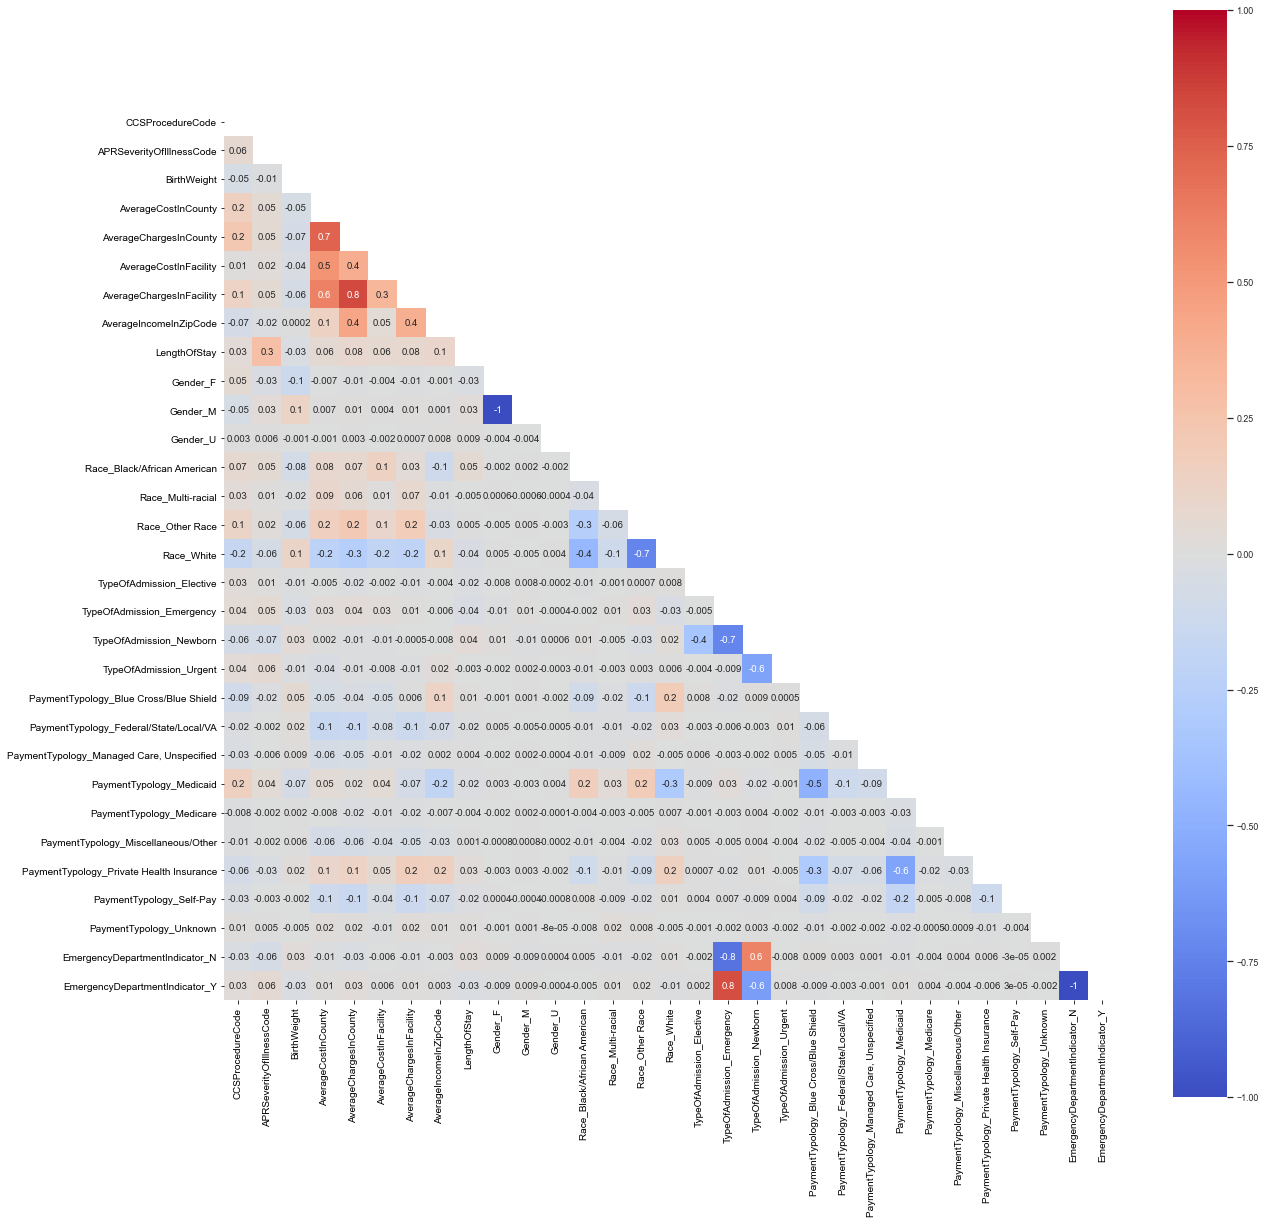

In [11]:
f, ax = plt.subplots(figsize=(20, 20))
dummies = pd.get_dummies(dataFrame)
matrix = np.triu(dummies.corr())
sns.set(font_scale=0.8)
sns.heatmap(dummies.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix, square=True)


###### 🧐 **Observations:**
> - This correlation matrix includes the categorical data in dummy encoded form.
> - There are some cost and charges features that highly correlate with each other:
    - AverageCostInCounty
    - AverageChargesInCounty 
    - AverageChargesInFacility
    - AverageCostInFacility
    - AverageIncomeInZipCode 
NOTE: Although in one case, AverageCostInFacility does not correlate with AverageIncomeInZipCode.
> - EmergencyDepartmentIndicator relates to itself heavily that for all the values that are Yes, the rest will 100% be No.
> - TypeOfAdmission_Emergency/_newborn and EmergencyDepartmentIndicator_Y/N are very correlated.
> - Other than that matrix of correlations with those features mentioned, there isn't many correlated features in this matrix, meaning a lot of the features are independant. 
> - Specifically because LengthOfStay is the target feature, it is no surprise that APRSeverityOfIllnessCode has some relation to how long a patient stays at hospital.
> - After splitting Male and Female categories, They are perfectly negatively correlated.

###### 👨🏻‍🎓 Conclusions
> - Since the correlation matrix does not include the categorical features, this correlation matrix needs to be re analysed against encoded features.
> -  Regression models are very sensative to correlated features.
> - Since there is not many correlated features, logistic regression seems like a promising model to examine. 
> - Do to a lack of correlated data, it will be assumed that they are independant of each other. If this is true Naive Bayes classifier could perform better compared than logistic regression, because of this, Naive Bayes will be examined as a model for this data as well.
> - There is a lot of hot encoded features, this is not good for traditional regression models, because they require continuous numerical data. Linear regression will not be examined because of this.
> - The male and female categories are full correlated and therefore Regularisation needs to be used for Logistic regression, this will remove the singularities for us. This applies as well for EmergencyDepartmentIndicator N & Y.

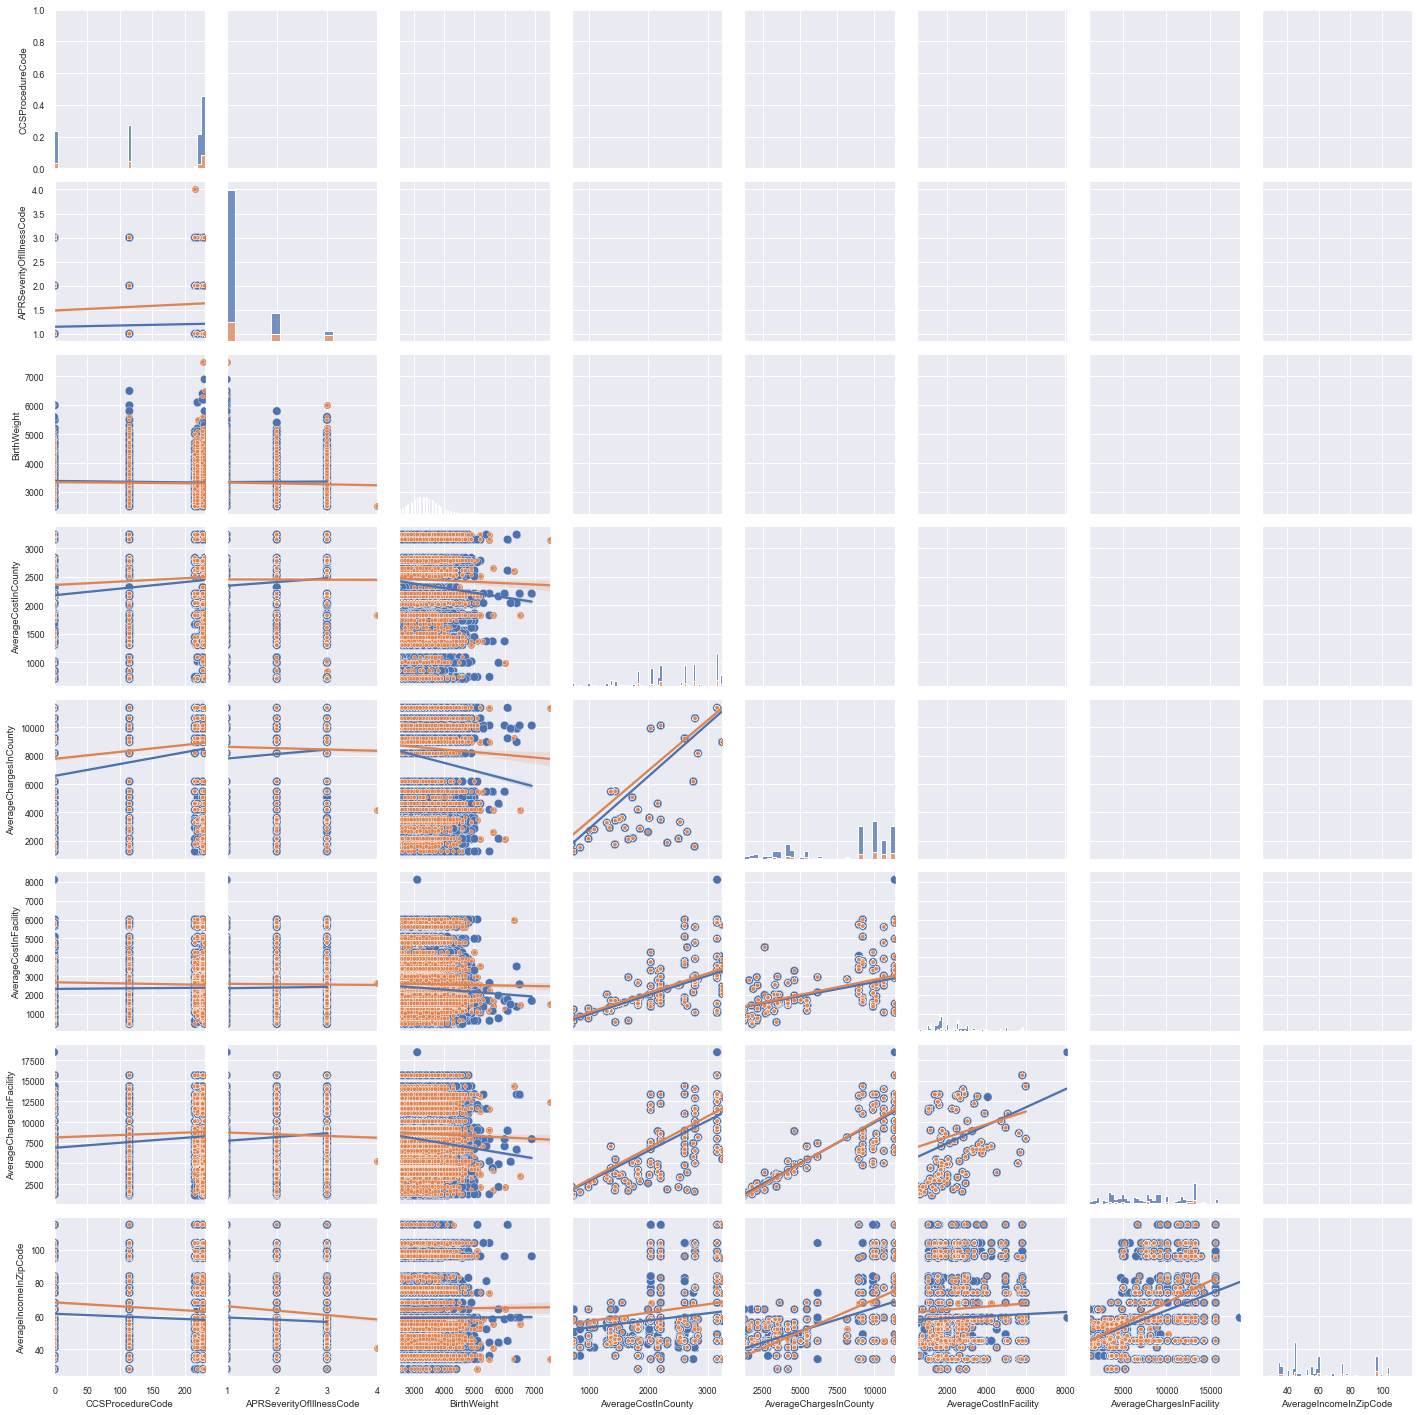

In [12]:
g = sns.PairGrid(dataFrame, hue="LengthOfStay")
g.map_lower(sns.regplot)
g.map_diag(sns.histplot, multiple="stack", element="step")
g.map_lower(sns.scatterplot, size=dataFrame["LengthOfStay"])

###### 🧐 **Observations:**
> - There isn't any obvious correlations that seperate LengthOfStay, between blue or orange. 
> - In most data points there is both blue and orange, meaning that length of stay has not be seperately very well between different correlations.
> - 45 degrre angled lines mean a high correlation.
> - The data is stacked tightly, and would require a high order polynomial model to split the data or classify it.\

###### 👨🏻‍🎓 Conclusions
> - Logistic regression is needed because it a simple low dimensional model cannot easily split the data, therefore a  high order model is needed such as Logistical regression. 
> - The Decision Tree classifiet is well known to over fit the data. It is needed though because there data is very nominal and categorical. Because this data doesn't seem easily split, it requires a deep tree model to discern a binary output. Averaging out multiple trees for this seems more probable of a better overall outcome rather than a single decision tree, so Random Forest Tree classifier will be examined as a model for this data.

### 1.3 - Data Splitting Analysis

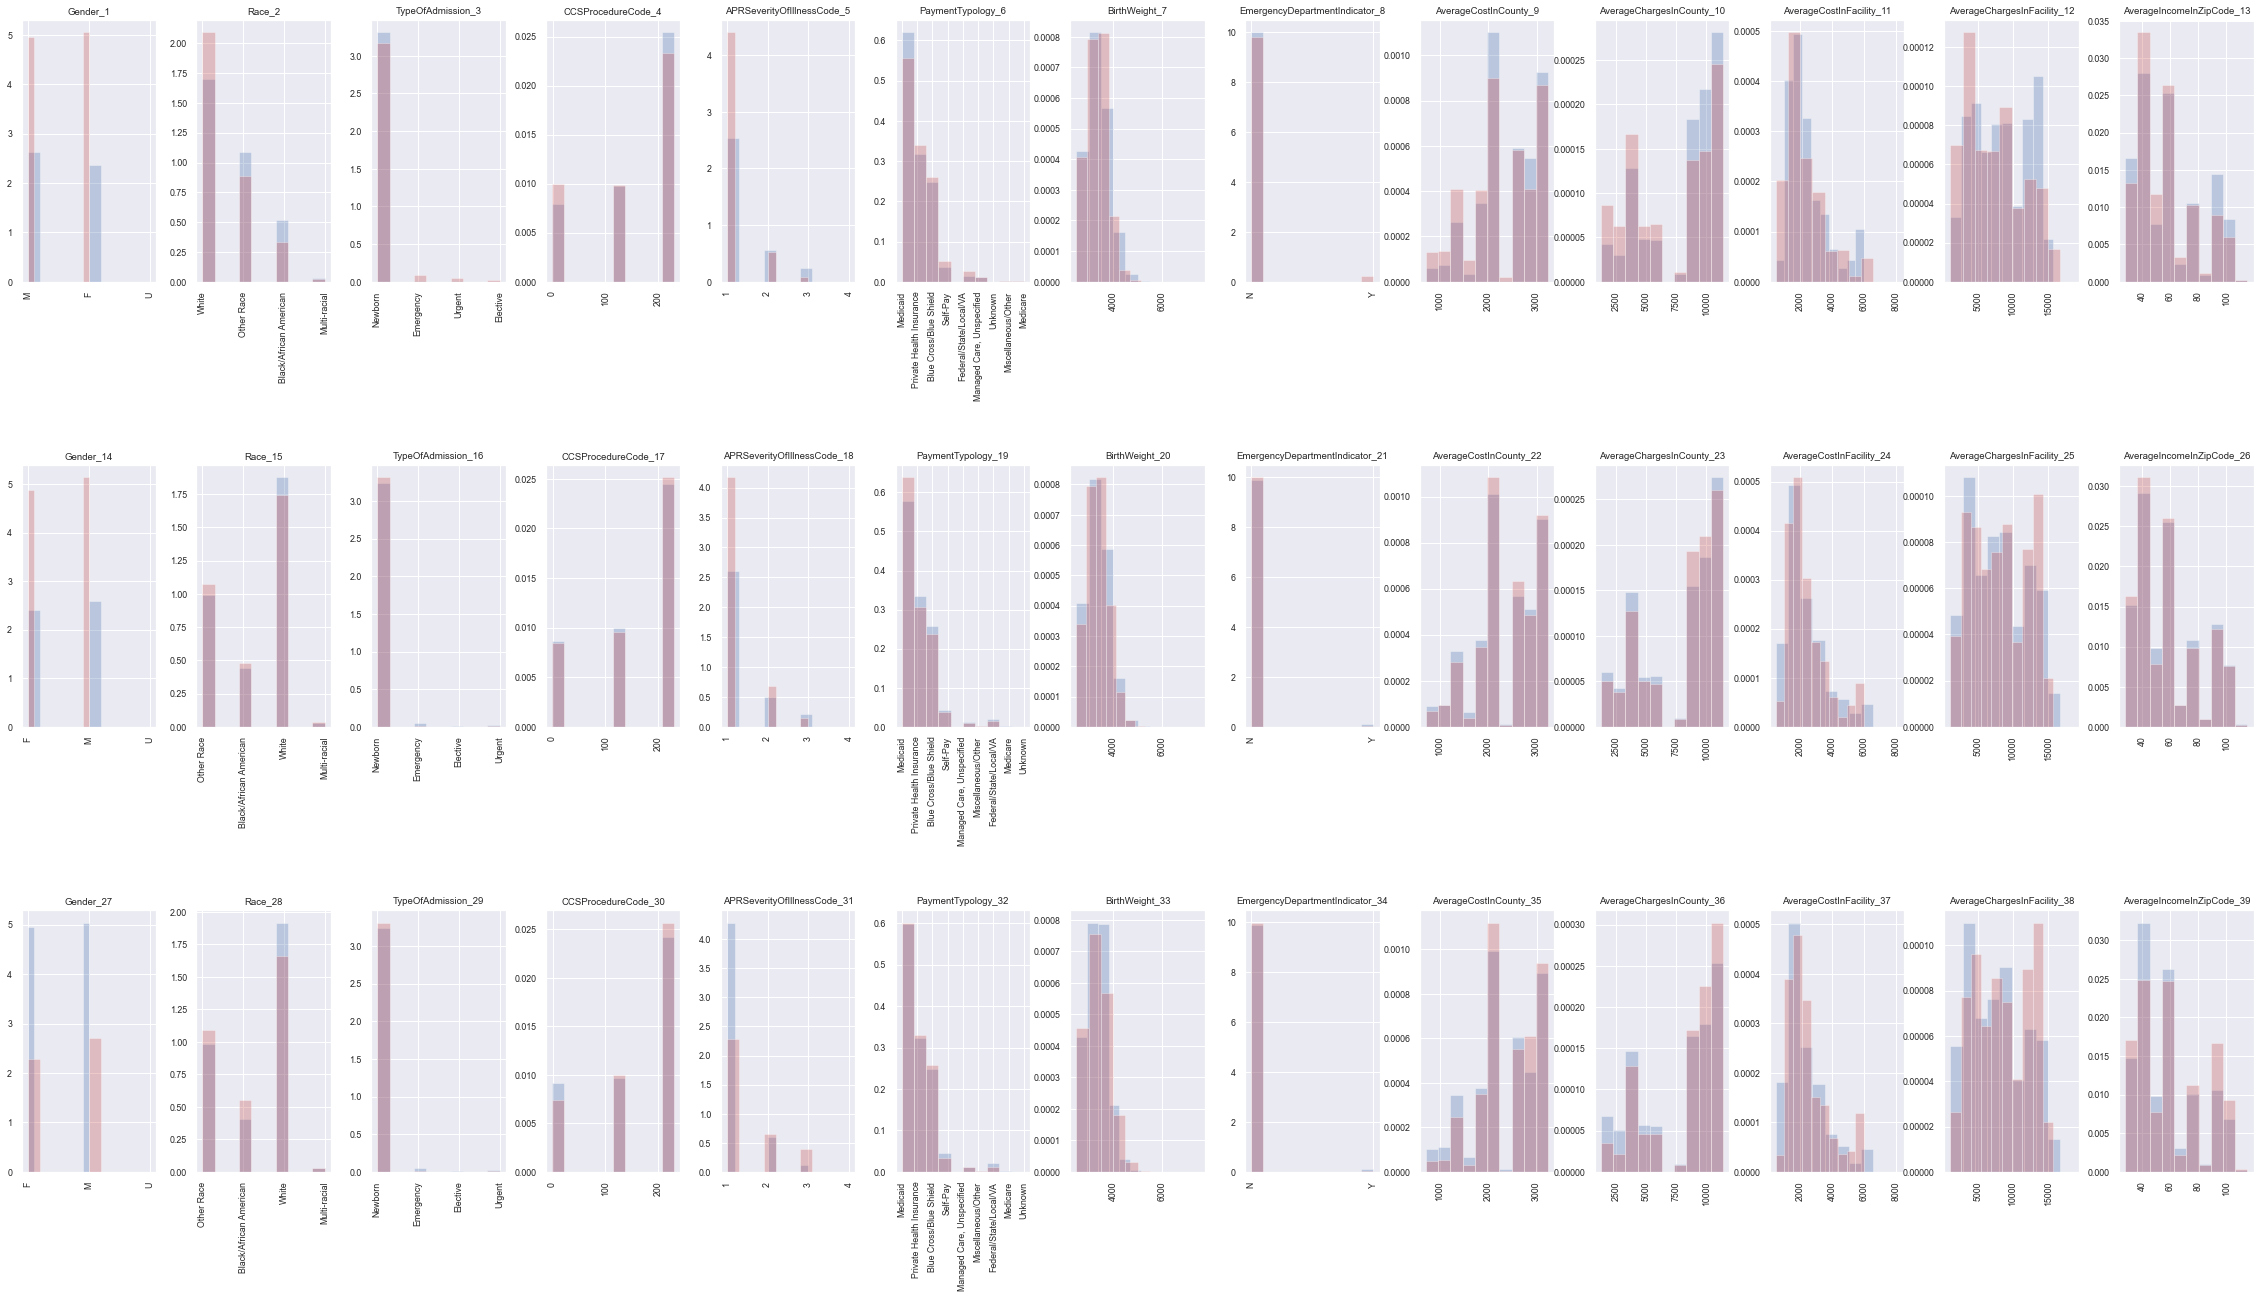

In [13]:
from numpy import array
from sklearn.model_selection import KFold

folds = 3
# prepare cross validation
kfold = KFold(n_splits=folds, random_state=None, shuffle=False)

plt.figure(figsize=(40,20))

k = 0
fold_count = 0
# enumerate splits
for train_index, test_index in kfold.split(patients_X):
    X_train, X_test = patients_X.iloc[train_index], patients_X.iloc[test_index]
    Y_train, Y_test = patients_Y.iloc[train_index], patients_Y.iloc[test_index]
 
    # Graph the results
    for i, col in enumerate(patients_X.columns):
        k+=1
        fold_count+=1
        hist_plot(col + "_" + str(fold_count), [X_train[col], X_test[col]], ['b', 'r'], folds, len(patients_X.columns), k)

###### 🧐 **Observations:**
> - The variation in training folds are massive in the 2nd column (Race).
> - The overlappings can be little such as 2 last column (AverageChargesInFacility), the train and test sets are not equally distributed.
> - Generated many iterations which will cause longer training time
\
###### 👨🏻‍🎓 Conclusions
> - K-Fold won't be used in logistical regression due to time constraints.

###### 1.3.1 Hold out validation


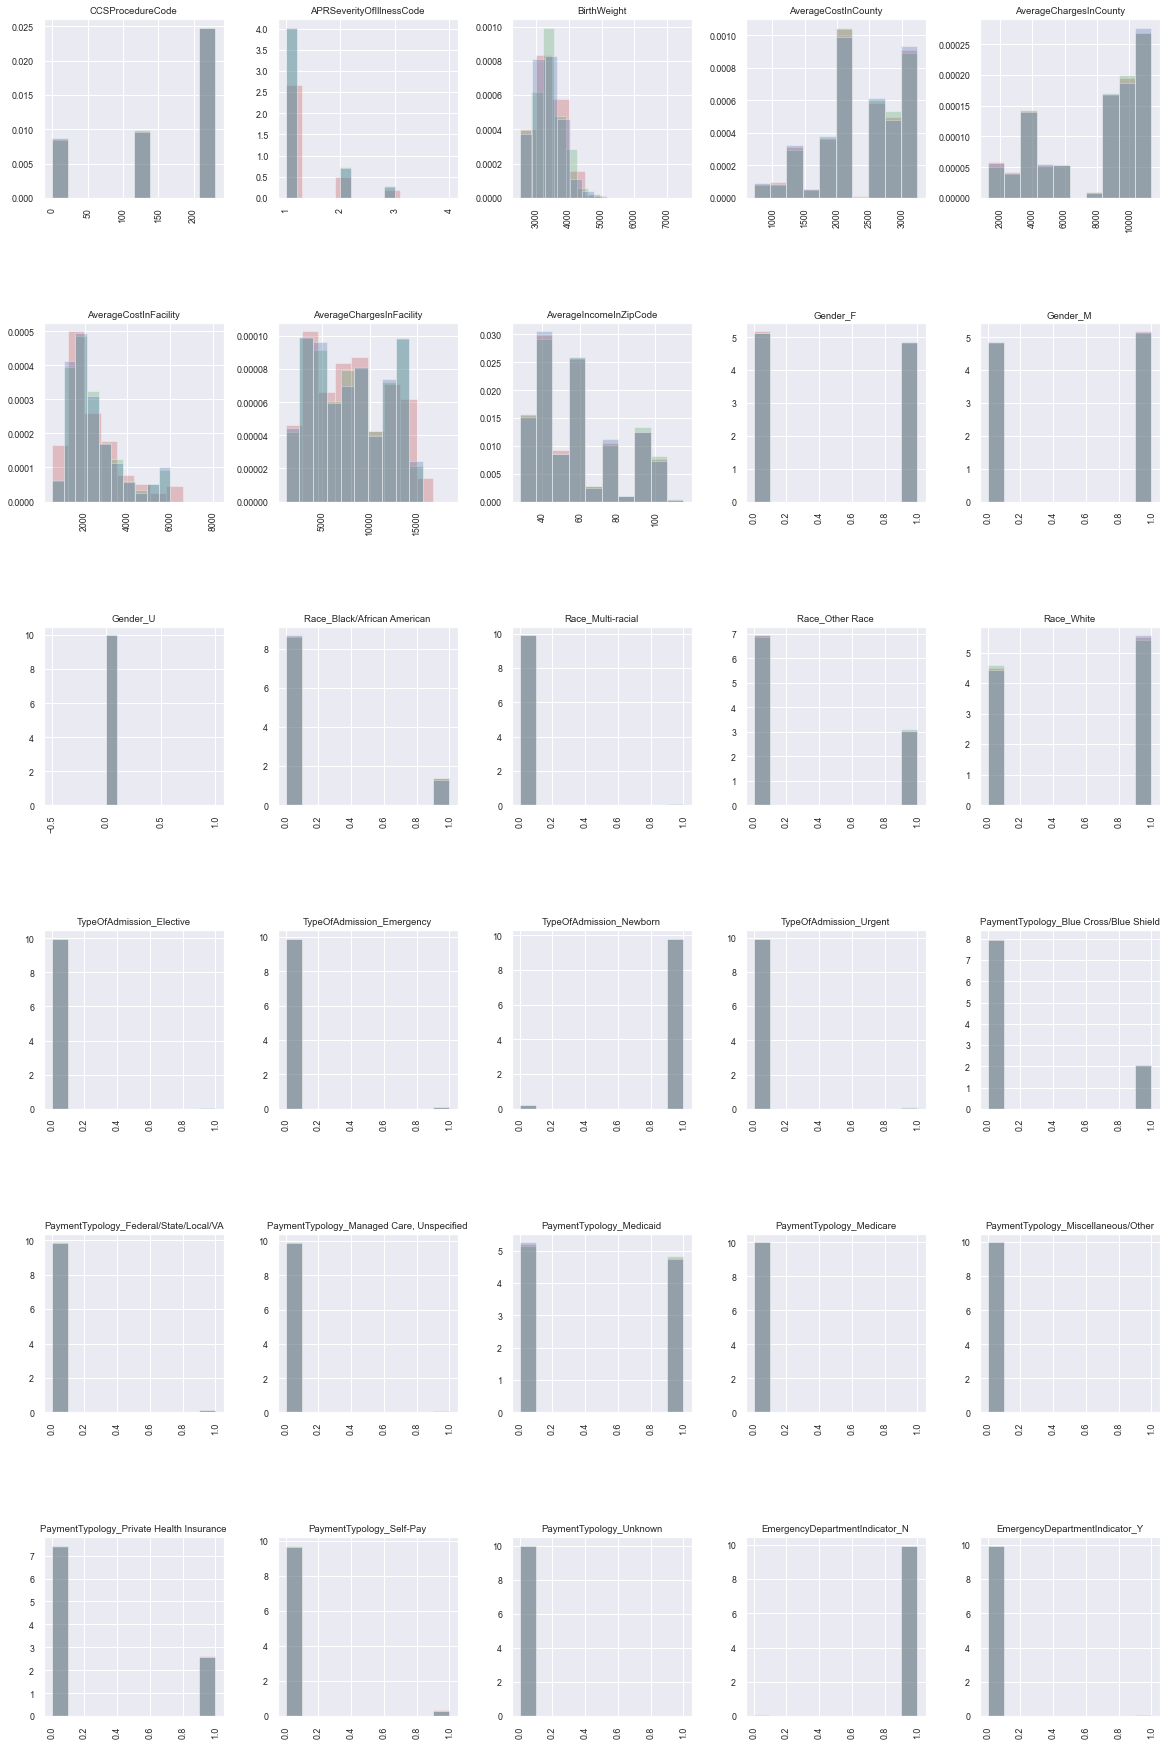

In [14]:
from sklearn.model_selection import train_test_split

def holdout_validation(train_size, X, Y):
    
    # 80% train = 20% Test, Split into 10% Validation & 10% Test, after
    test_size = 1 - train_size
    
    # Split into train and test for normal and target fields set, 20% is for validation and test.
    with pd.option_context('mode.chained_assignment', None):
        train_X, X_test_, train_Y, Y_test_ = train_test_split(X, Y, test_size=test_size, shuffle=True,random_state=0)

    # Split the test data into validation test and test.
    # Do for target field and normal fields.
    with pd.option_context('mode.chained_assignment', None):
         val_X, test_X, val_Y, test_Y = train_test_split(X_test_, Y_test_, test_size=0.5, shuffle=True, random_state=29)
    return train_X, val_X, test_X, train_Y, val_Y, test_Y

patients_X_dummies = pd.get_dummies(patients_X)
hv_train_X, hv_val_X, hv_test_X, hv_train_Y, hv_val_Y, hv_test_Y = holdout_validation(0.8, patients_X_dummies, patients_Y)

# Graph the results
plt.figure(figsize=(20,40))
for i, col in enumerate(patients_X_dummies.columns):
    hist_plot(col, [hv_train_X[col], hv_val_X[col], hv_test_X[col]], ['r', 'g', 'b'], 8, 5, i+1)

###### 🧐 **Observations:**
> - The data seems to be fairly evenly split (very good overlap), however the amount of one sided biases there are is concerning and now emphasises how important regularisation is for Logistic regression. Decision tree models will address this inherently. Some of these features need to be eliminated because they repeat the same data such as Male and Female, look how identical they are, which explains why they have a -1 correlation, regularisation needs to cull these fields.
\
###### 👨🏻‍🎓 Conclusions
> - Lasso regularisation uses L1 and shrinks coefficients of features, making them effectively useless (eliminating them), however it can take some time to iterate on L1. 

# 2 - Feature Scaling Analysis
Feature scaling is only required for Logistic Regression and is needed because in previous EDA we think Logistical Regression could potentially turn out differently that Decision Tree models. Naive Bayes and Random Forest are not affected by scaling since the scale of the data does not change choosing the left from the right branches. Therefore, the judgments for this analysis will be made soley for Logistic Regression.

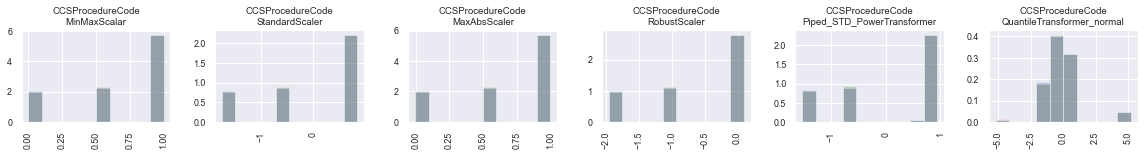

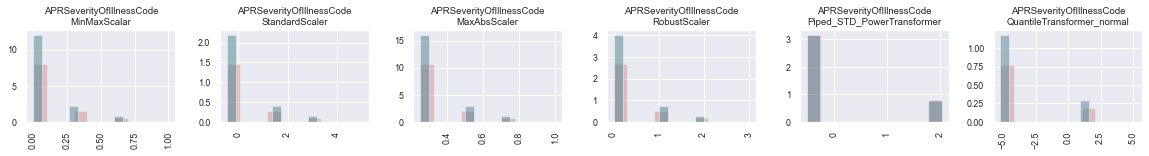

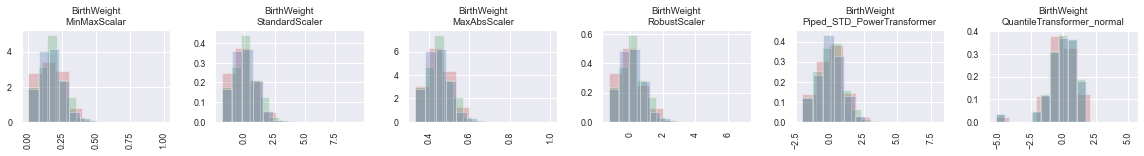

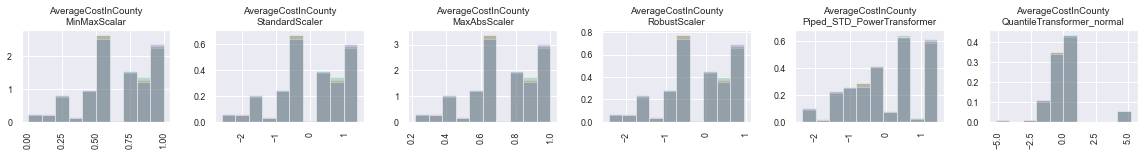

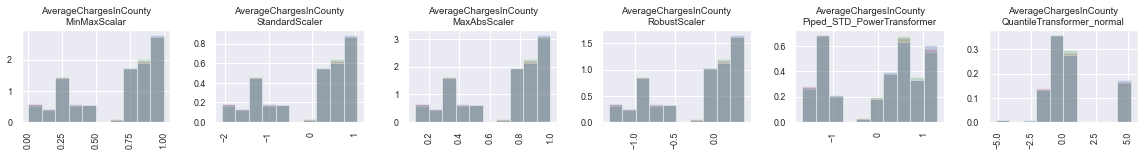

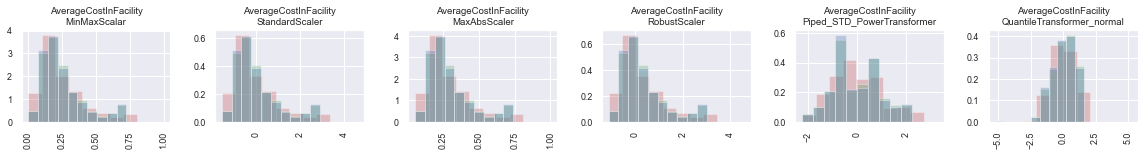

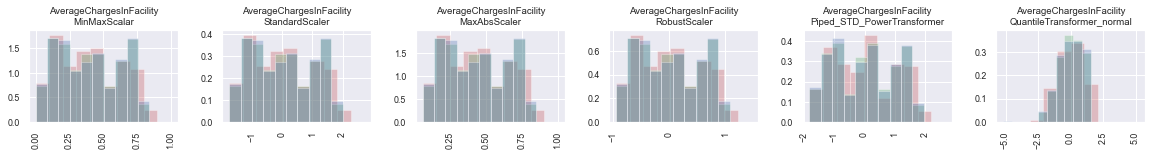

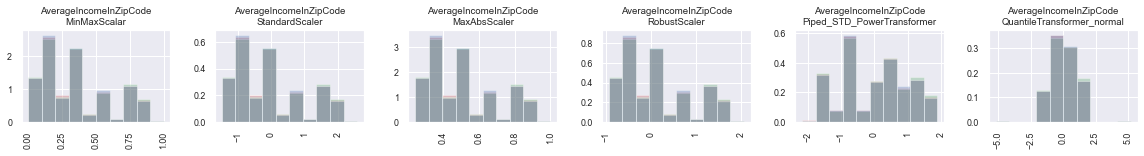

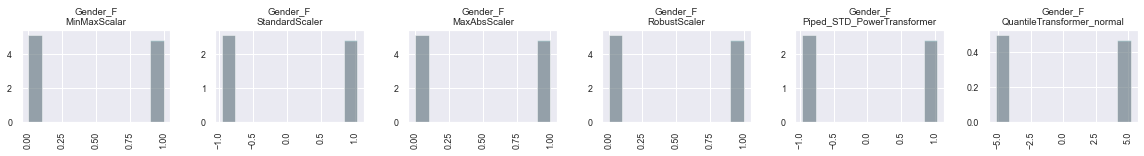

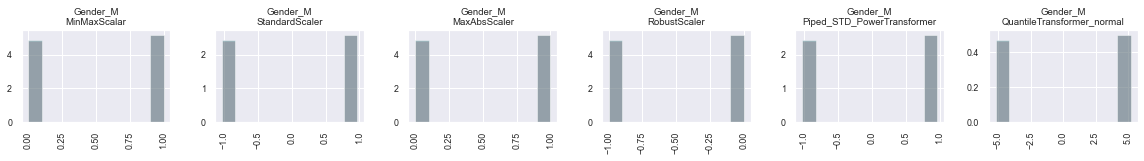

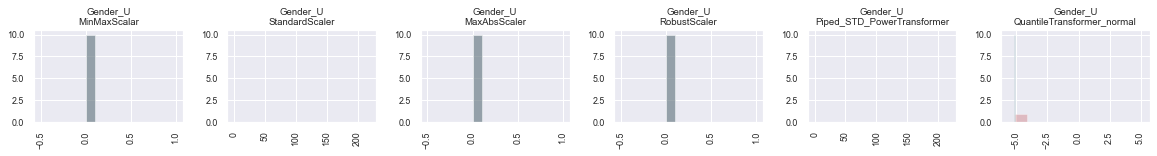

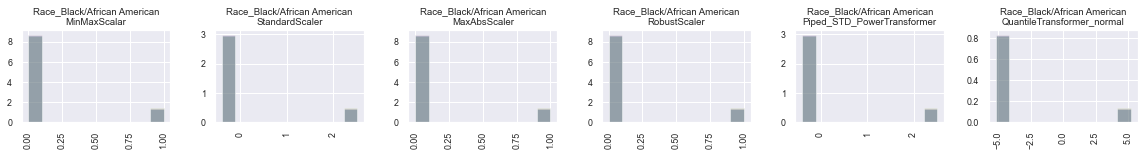

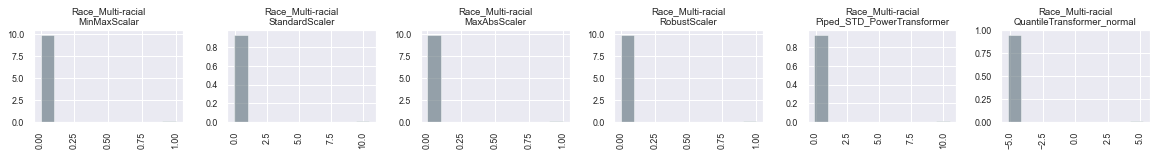

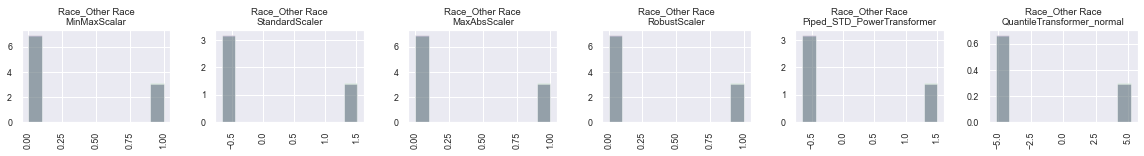

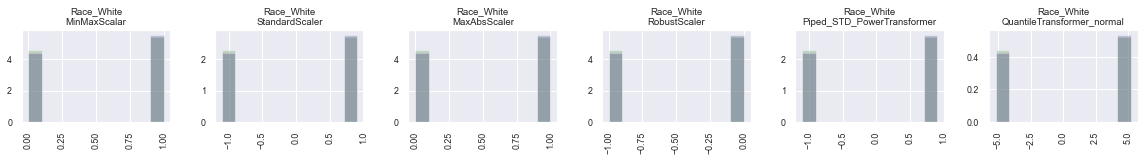

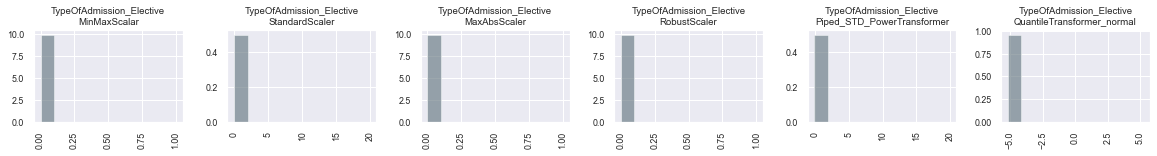

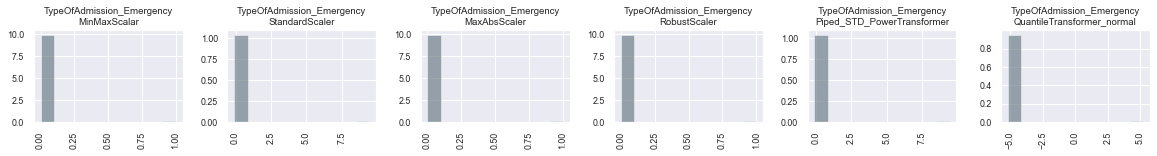

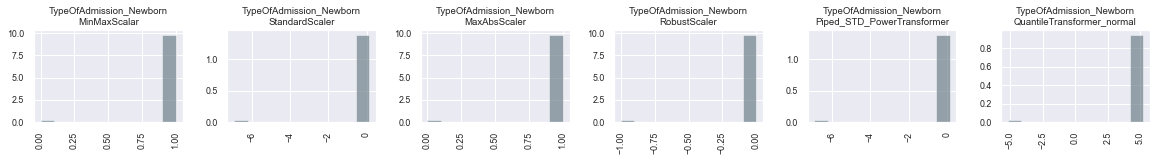

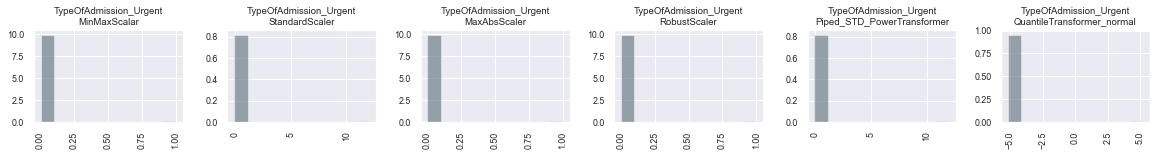

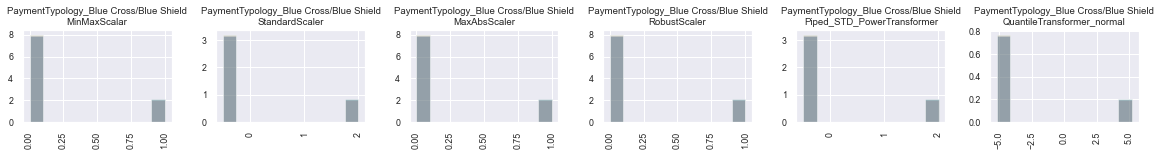

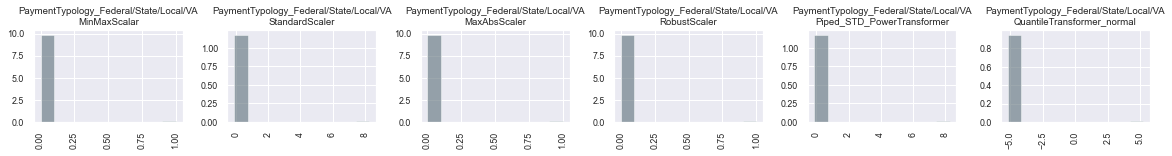

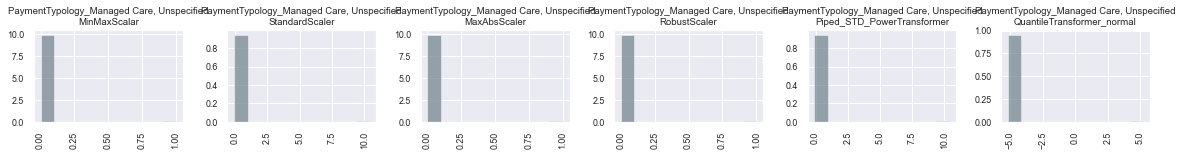

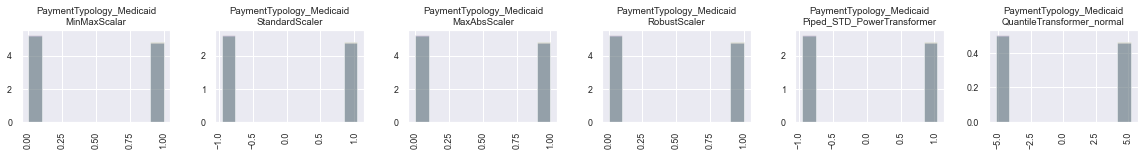

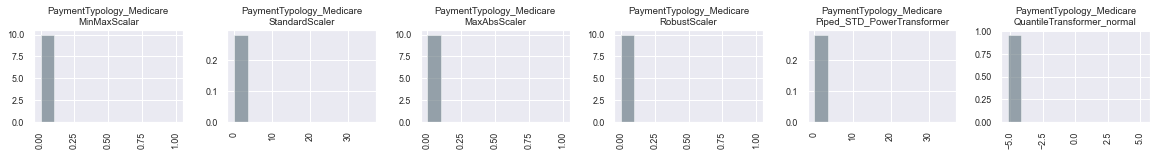

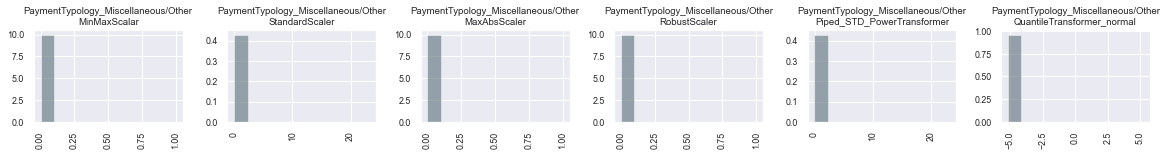

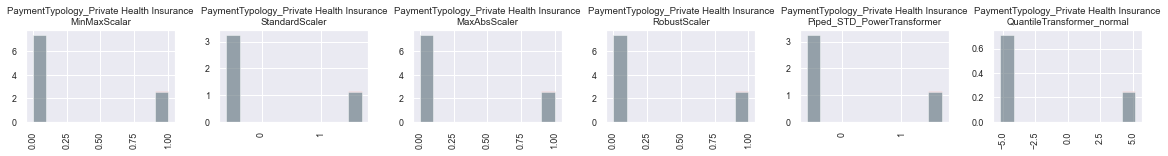

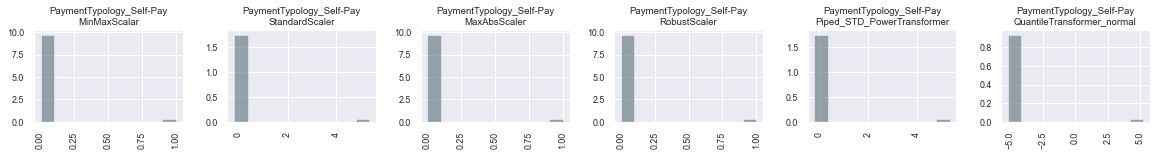

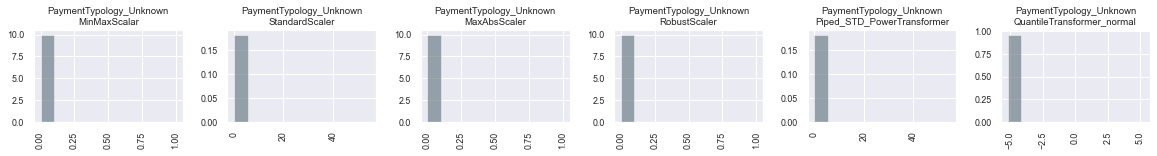

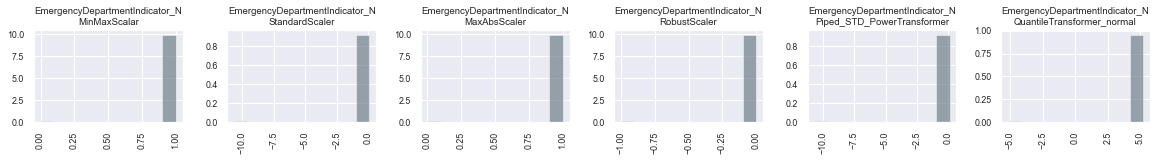

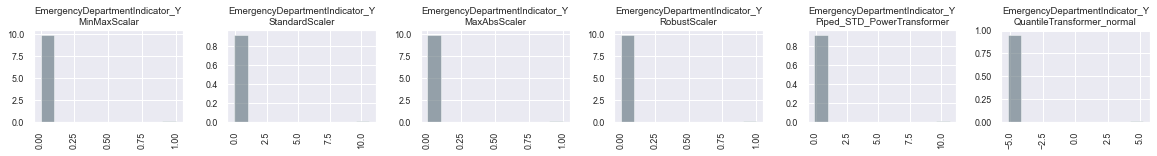

In [15]:
from sklearn.pipeline import make_pipeline

plt.rcParams.update({'figure.max_open_warning': 0})

count = 0
fields = patients_X_dummies.columns
for field in fields:
    train = hv_train_X[[field]]
    scalars = [
        (0, "MinMaxScalar", MinMaxScaler().fit(train)),
        (1, "StandardScaler", StandardScaler().fit(train)),
        (2, "MaxAbsScaler", MaxAbsScaler().fit(train)),
        (3, "RobustScaler", RobustScaler(quantile_range=(25, 75)).fit(train)),
        (4, "Piped_STD_PowerTransformer", make_pipeline(StandardScaler(with_std=False), PowerTransformer(method='yeo-johnson', standardize=True)).fit(train)),
        (5, "QuantileTransformer_normal", QuantileTransformer(output_distribution='normal', n_quantiles=10, random_state=0).fit(train)),
    ]
    
    plt.figure(figsize=(20,80))
    for j, title, scalar in scalars:
        count+=1
        hist_plot(field + "\n" + title, [scalar.transform(hv_train_X[[field]]), scalar.transform(hv_val_X[[field]]), scalar.transform(hv_test_X[[field]])], ['r','g','b'], len(fields), len(scalars), count)

###### 🧐 **Observations:**
> - A lot of the scalers almost have identical results on the data visually.
> - Power Transformer seems to only sometimes center the data, like for AverageCostInFacility, but not for BirthWeight.
> - Quantile transformer did what was expected and on the outliers found in the EDA for Birthweight, it corrected it and centered the data, which was something PowerTransformer did not do.
> - Only Standard Scaler and Quantile Transformer correctly normalised Gender Unknown to be less weighted since there is only 1 record of it in the data. So it was correctly normalised.
\
###### 👨🏻‍🎓 Conclusions
> - Quantile Transformer seems to be more reliable with normalising the data across the board, therefore this will be the scaler chosed for Logistical Regression.

# 3 Performance Metrics
As per the EDA, accuracy and precision alone are not going to give indicative results of how well the model will perform due to the data being so lop sided sometimes, therefore it was decided that f1 score will be the performance measure to evenly account for all the aspects of performance and not give all the bias to one measure. However MAPE will also be used to try forecast error in the model, though again, f1 is prefered.

In [59]:
from sklearn.metrics import f1_score

def get_f1_scores(clf, train_X, train_Y, val_X, val_Y, test_X, test_Y):
    train_pred = clf.predict(train_X)
    val_pred = clf.predict(val_X)
    test_pred = clf.predict(test_X)
        
    train_f1 = f1_score(train_Y, train_pred, average='macro')
    val_f1 = f1_score(val_Y, val_pred, average='macro')
    test_f1 = f1_score(test_Y, test_pred, average='macro')
    
    return train_f1, val_f1, test_f1

# 4 - Methodology Selection
As discussed in the EDA, this problem is a classification problem. The models that are classification models are:
 - Logistical Regression
 - Naive Bayes
 - Random Forest

In order to move onto the hyper parameter selection strategy, the speeds at which each model can be trained is very important to how many iterations can be made in the time constraints of this project. Unfortunately this will have to be the measure, or else this report will not be finished in time.

### 4.1 - Regularised Polynomial Logistic Regression Model 
Here I experiment using one of the restricted models we have learnt so far. \
In the EDA we can see that a the data is very hard to seperate from a low dimensional perspective and so Logistic Regression is required for this data. However, when it comes to the charges in facility and charges in county, there is some good correlation. With those correlated fields, regularisation could possibly be justified.
In Polynomial regression we apply it to the continuous numerical features, to get the power of those features. It is not applied to One Hot encoded features because the power of 1 is 1 and so useless. The less features the better for this model because more features means more training time.

###### Apply Regularisation
As from the EDA, regularisation is needed to combat the correlations between male and female, Emergency Yes or No and the 1 sided categorical data. L1 is a better for dropping features and therefore great for feature selection, this is what will be used.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

# Encode the categorical data in order to split it all.
patients_X_dummies = pd.get_dummies(patients_X)

# Split
train_X, val_X, test_X, train_Y, val_Y, test_Y = holdout_validation(0.8, patients_X_dummies, patients_Y)

train_X_scaled = train_X.copy()
val_X_scaled = val_X.copy()
test_X_scaled = test_X.copy()

# Scale continuous noncategorical features using minmax TODO Why Minmax scaler and not powerscaling?
quantileTransformer = QuantileTransformer(output_distribution='normal', n_quantiles=10, random_state=0).fit(train_X_scaled.loc[:, ordinal_numerical_features])
train_X_scaled.loc[:, ordinal_numerical_features] = quantileTransformer.transform(train_X_scaled.loc[:, ordinal_numerical_features])
val_X_scaled.loc[:, ordinal_numerical_features] = quantileTransformer.transform(val_X_scaled.loc[:, ordinal_numerical_features])
test_X_scaled.loc[:, ordinal_numerical_features] = quantileTransformer.transform(test_X_scaled.loc[:, ordinal_numerical_features])

poly = PolynomialFeatures(3)
poly.fit(train_X)
train_X = poly.transform(train_X)
test_X = poly.transform(test_X)
val_X = poly.transform(val_X)

lr = LogisticRegression(penalty='l1', C = 0.169, random_state=0,
                       solver='liblinear', max_iter=1000, n_jobs=-1, 
                       class_weight='balanced').fit(train_X, train_Y.ravel())
    
train_f1, val_f1 = get_f1_scores(lr, train_X, train_Y, val_X, val_Y)
print("Train F1-Score score: {:.3f}".format(train_f1))
print("Validation F1-Score score: {:.3f}".format(val_f1))

##### NOTICE: Unfortunately due to time contraints, Logistical Regression could not be fully tested

### 4.2 - Naive Bayes

In [34]:
from sklearn.naive_bayes import GaussianNB
import timeit

patients_X_dummies = pd.get_dummies(patients_X)
train_X, val_X, test_X, train_Y, val_Y, test_Y = holdout_validation(0.8, patients_X_dummies, patients_Y)

GB = GaussianNB().fit(train_X, train_Y)
train_f1, val_f1, test_f1 = get_f1_scores(GB,train_X, train_Y, val_X, val_Y, test_X, test_Y)
print("Train f1 score: {:.3f}".format(train_f1))
print("Validation f1 score: {:.3f}".format(val_f1))
print("Test f1 score: {:.3f}".format(test_f1))


Train f1 score: 0.614
Validation f1 score: 0.598
Test f1 score: 0.608
Time elapsed:  -0.0067636000001130014


### Unfortunately due to time constraints, Naive Bayes could not be fully tested with Random and then grid based hyper parameter search. 
If I had enough time to perform such searches, it would be the same as what has been done with the RandomForest calssifier below. First random grid search then narrow down with grid based searches.

(array([-0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

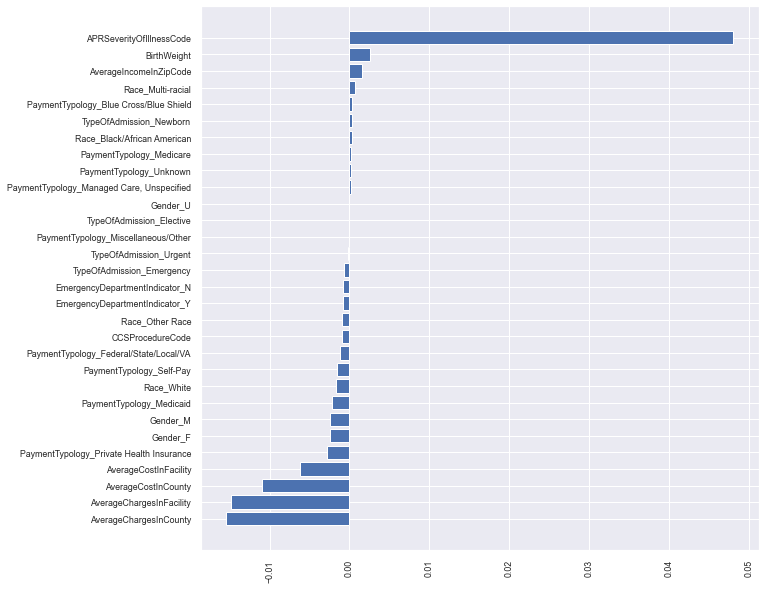

In [38]:
from sklearn.inspection import permutation_importance

imps = permutation_importance(GB, test_X, test_Y)
inx = np.argsort(imps.importances_mean)

fig = plt.figure(figsize=(10,10))
plt.barh(test_X.columns[inx], imps.importances_mean[inx])
plt.xticks(rotation='vertical')


### 4.3 - Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

patients_X_dummies = pd.get_dummies(patients_X)
train_X, val_X, test_X, train_Y, val_Y, test_Y = holdout_validation(0.8, patients_X_dummies, patients_Y)

RFC = RandomForestClassifier(max_depth=8, n_estimators=500, class_weight='balanced_subsample', random_state=0)
RFC.fit(train_X, train_Y)

train_f1, val_f1, test_f1 = get_f1_scores(RFC, train_X, train_Y, val_X, val_Y, test_X, test_Y)
print("Train f1 score: {:.3f}".format(train_f1))
print("Validation f1 score: {:.3f}".format(val_f1))
print("Test f1 score: {:.3f}".format(test_f1))


Train f1 score: 0.675
Validation f1 score: 0.641
Test f1 score: 0.647
Time elapsed:  0.00026800000000548607


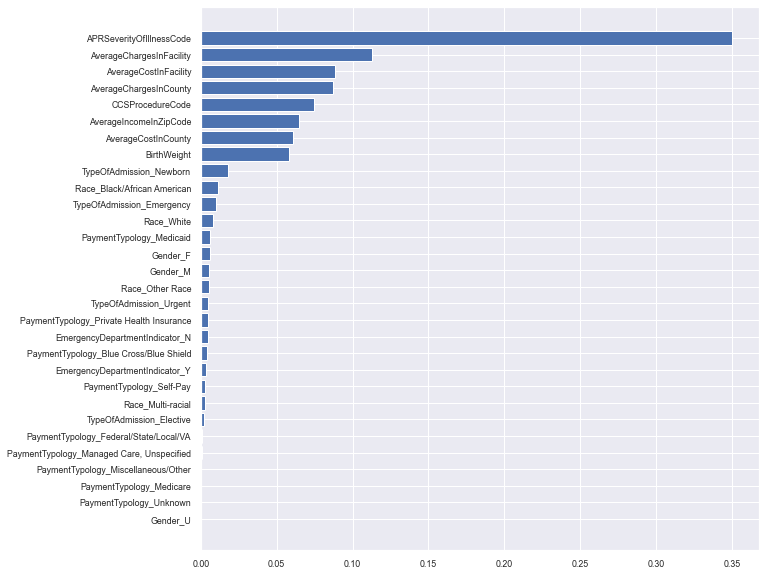

In [30]:
tree_feature_importances = RFC.feature_importances_
sorted_idx = tree_feature_importances.argsort()

plt.figure(figsize=(10,10))
plt.barh(patients_X_dummies.columns[sorted_idx], tree_feature_importances[sorted_idx])
plt.show()

As expected from the EDA, APRSeveirtyOfIllnessCode is of massive importance when making a prediction.

# 5 - Hyper Parameter Selection Strategy

Selecting the correct hyper parameter selection strategy is pivotal. The strategy for RandomForest will first be to explore the parameter space using random grid search. Then after that grid search will be used to search around the best area found by random grid search to further find the best parameters in the parameter space.

In [55]:
# Minimum number of samples required to split a node.
min_samples_split = [2, 5, 10]

# Number of features to consider at every split.
max_features = ['auto', 'sqrt']

# Maximum levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 2)]
max_depth.append(None)

# Selecting samples for training each tree?
bootstrap = [True, False]

# Number of trees.
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 700, num = 10)]

# Minimum number of samples required at each leaf node.
min_samples_leaf = [1, 2, 4]

# Create the random grid
parameters_rand = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [56]:
from sklearn.model_selection import RandomizedSearchCV

# Encode the categorical features.
patients_X_dummies = pd.get_dummies(patients_X)

# Hold out 80% for training and 10% for validation and 10% for testings.
train_X, val_X, test_X, train_Y, val_Y, test_Y = holdout_validation(0.8, patients_X_dummies, patients_Y)

# The model, use values of Y to automatically adjust weights.
rfc = RandomForestClassifier(class_weight='balanced_subsample', random_state=0)
rf_random = RandomizedSearchCV(estimator=rfc, scoring='neg_mean_absolute_error', param_distributions=parameters_rand,
                              n_iter = 200, return_train_score=True, cv = 3, verbose=2, n_jobs=-1, random_state=69)
rf_random.fit(train_X, train_Y)

print("Best Score: ", rf_random.best_score_)
print("Best Parameters: ", rf_random.best_params_)

clf = rf_random.best_estimator_

# Get scores
train_f1, val_f1, test_f1 = get_f1_scores(clf, train_X, train_Y, val_X, val_Y, test_X, test_Y)
print("Train f1 score: {:.3f}".format(train_f1))
print("Validation f1 score: {:.3f}".format(val_f1))
print("Test f1 score: {:.3f}".format(test_f1))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 37.9min finished


Best Score:  -0.2057866938833519
Best Parameters:  {'n_estimators': 422, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
Train f1 score: 0.903
Validation f1 score: 0.589
Test f1 score: 0.606
Time elapsed:  0.0013279000013426412


As you can see from the results, the training set has done very well, but the validation set and test set have equally not. This means that the results are heavily overfitted and the parameters need to be changed. The manual changes I added to account for this were making the max depth parameters 10, 13, 16 because 30 seemed a little high.

### Grid Search
Next we refine further by searching around the best found parameters off the random search, using a grid based search.
We can now perform grid search building from the random search. We will test a range of hyperparameters around the best values returned by random search.

In [61]:
parameters_grid = {
    'bootstrap': [True],
    'max_depth': [10, 13, 16, 30, 35],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [300, 400, 500]
}


from sklearn.model_selection import GridSearchCV


rf_clf = RandomForestClassifier(class_weight='balanced_subsample', random_state=0)
Gridclf = GridSearchCV(estimator = rf_clf, param_grid = parameters_grid, 
                                 cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)
Gridclf.fit(train_X, train_Y)

print("Best Score: ", Gridclf.best_score_)
print("Best Parameters: ", Gridclf.best_params_)

clf = Gridclf.best_estimator_

train_f1, val_f1, test_f1 = get_f1_scores(clf, train_X, train_Y, val_X, val_Y, test_X, test_Y)
print("Train f1 score: {:.3f}".format(train_f1))
print("Validation f1 score: {:.3f}".format(val_f1))
print("Test f1 score: {:.3f}".format(test_f1))


Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  7.2min finished


Best Score:  0.7886892260782452
Best Parameters:  {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 500}
Train f1 score: 0.827
Validation f1 score: 0.628
Test f1 score: 0.649


There was a 5% increase in accuracy with validation and test score.

### Grid Search Round 2
The second round of grid search will be to hone in on more finely tuned parameters around the next best parameter space.

In [62]:
parameters_grid_2 = {
    'bootstrap': [True],
    'max_depth': [11, 12, 13, 15, 16, 17, 18],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [8],
    'n_estimators': [500]
}

from sklearn.model_selection import GridSearchCV


rf_clf = RandomForestClassifier(class_weight='balanced_subsample', random_state=0)
Gridclf = GridSearchCV(estimator = rf_clf, param_grid = parameters_grid_2, 
                                 cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)
Gridclf.fit(train_X, train_Y)

print("Best Score: ", Gridclf.best_score_)
print("Best Parameters: ", Gridclf.best_params_)

clf = Gridclf.best_estimator_

train_f1, val_f1, test_f1 = get_f1_scores(clf, train_X, train_Y, val_X, val_Y, test_X, test_Y)
print("Train f1 score: {:.3f}".format(train_f1))
print("Validation f1 score: {:.3f}".format(val_f1))
print("Test f1 score: {:.3f}".format(test_f1))

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  21 | elapsed:   48.5s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  1.4min finished


Best Score:  0.7847076373622556
Best Parameters:  {'bootstrap': True, 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 500}
Train f1 score: 0.772
Validation f1 score: 0.645
Test f1 score: 0.666


### Ultimate Judgment / Final Model
Put the best found parameters into the final model

In [63]:
patients_X_dummies = pd.get_dummies(patients_X)
train_X, val_X, test_X, train_Y, val_Y, test_Y = holdout_validation(0.9, patients_X_dummies, patients_Y)

RFC2 = RandomForestClassifier(max_depth=18, bootstrap=True, max_features='sqrt', 
                              min_samples_leaf=1, min_samples_split=8, n_estimators=500, 
                              class_weight='balanced_subsample', random_state=0)
RFC2.fit(train_X, train_Y)

train_f1, val_f1, test_f1 = get_f1_scores(RFC2, train_X, train_Y, val_X, val_Y, test_X, test_Y)
print("Train f1 score: {:.3f}".format(train_f1))
print("Validation f1 score: {:.3f}".format(val_f1))
print("Test f1 score: {:.3f}".format(test_f1))

Train f1 score: 0.764
Validation f1 score: 0.664
Test f1 score: 0.654


### Making the predictions

In [93]:
import csv

raw_test_dataFrame = pd.read_csv('./data/test_data.csv', delimiter=',')

# Encode
test_X_dummies = pd.get_dummies(raw_test_dataFrame)

# drop the features that the model auto removed
dataFrame_X = test_X_dummies.drop(list(set(test_X_dummies.head()) - set(train_X.head())), axis=1)

with open('./data/s3630120_predictions.csv', mode='w', newline='') as predictions_file:
    predictions_writer = csv.writer(predictions_file, delimiter=',')
    predictions_writer.writerow(['ID', 'LengthOfStay'])
    
    preds = RFC2.predict(dataFrame_X)
    count = 0
    for prediction in preds:
        count+=1
        predictions_writer.writerow([count, prediction])